In [ ]:
# VERY DUMB model for understanding how sure we can be about ILD predictions
#  - how does variable predictiveness of ILD matter
#  - how many patients do we need

# X) Make ILD predictions
#    - just use gamma distribution
# 1) Write code to (for a given set of gamma distributions):
#  X  i) Run 10k simulations
#  -  ii) Calculate how often X% ILD-development true positive and Y% ILD-development false positive, (X ~75, Y ~20)
#  X  iii) See how rates in (ii) change as function of X
#  X  iv) See how rates in (ii) change as function of Y
#  X  v) See how rates in (ii) change as function of nILDPositive
# 
# 2) Save some 'Monte Carlo'
#  X i) generate distributions as ftn of gamma shape
#  X ii) calculate threshold rates for some set tpr/fpr threshold values
#  X iii) save list in .csv / pandas DF
#  - iv) make some simple plots with mean/std showing shape (X) vs TPR (Y, mean+/-std) for fixed FPR
#  X v) figure out meaningful way to fit numpy hists

# 3) Calculate some significance bands 
#    - how good were the predictions
#    - $10k: how many cases do we need to have model confidence

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from sklearn.metrics import roc_curve, auc

In [5]:
def returnGammaDistribution( _shape, _scale, _nSamples, invert=False):
    """function to produce dummy algorithm scores"""
    
    _gamma = np.random.gamma(_shape, _scale, (int(_nSamples)))
    if invert:
        _gamma = -1*_gamma
    _gamma = _gamma - min(_gamma)
    _gamma = _gamma / max(_gamma)
    
    return _gamma

def produceTwoDistributions( shape, scale, nSamples, showPlots=True):
    """wrapper to make binary class predictions and compare"""
    
    _nonILD = []
    _ILD = []
    
    # *** 1. Generate some predictions + labels
    if type(shape)==int:
        _nonILD = returnGammaDistribution( shape, scale, nSamples)
        _ILD    = returnGammaDistribution( shape, scale, nSamples, invert=True)
    else:
        _nonILD = returnGammaDistribution( shape[0], scale[0], nSamples[0])
        _ILD    = returnGammaDistribution( shape[1], scale[1], nSamples[1], invert=True)

    _ILD_labels = np.ones( len(_ILD))
    _nonILD_labels = np.zeros( len(_nonILD))

    # *** 2. Plot to compare
    if showPlots:
        plotPredictions(_nonILD, _ILD)
    
    # *** 3. Concatenate results
    _y_pred = np.concatenate((_nonILD, _ILD))
    _y_true = np.concatenate((_nonILD_labels, _ILD_labels))
    
    # *** 4. Calculate AUC and make ROC curve
    _fpr, _tpr, _thresh = roc_curve(_y_true, _y_pred)
    _roc_auc = auc(_fpr, _tpr)
    
    # *** 5. Plot ROC
    if showPlots:
        plotROC(_roc_auc, _fpr, _tpr)
        
    return dict( auc= _roc_auc, fpr= _fpr, tpr= _tpr, nonILD= _nonILD, ILD= _ILD )

def plotROC(_roc_auc, _fpr, _tpr):
    """function for plotting ROC"""
    
    plt.plot(_fpr, _tpr, color='darkorange',         
            lw=2, label='ROC curve (area = %0.2f)' % _roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.ylim([0.0, 1.05])
    
    plt.xlim([0.0, 1.0])
    #plt.xscale('log')
    #plt.xlim([5e-4, 1.05])
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return

def plotPredictions(_nonILD, _ILD):
    """function for plotting two distributions"""
    
    _transparency = 0.5
    _nBins = 20
   
    plt.hist( _nonILD , bins=_nBins, alpha=_transparency )
    plt.hist( _ILD , bins=_nBins, alpha=_transparency )  
    plt.xlabel("ILD Development Score")
    plt.ylabel("Number of Clinical Patients")
    plt.show()

    return

def getRateGivenThreshold(_threshold, _thresholdRate, _dependentRate):
    """function to return false (true) positive rate given true (false) positive rate threshold"""
    
    for _i in np.arange(0, len(_thresholdRate)):
        if _thresholdRate[_i]>= _threshold:
            break

    #print(_i, _thresholdRate[_i-1], _thresholdRate[_i], _thresholdRate[_i+1])
    #print(_i, _dependentRate[_i-1], _dependentRate[_i], _dependentRate[_i+1])
    
    if np.abs(_thresholdRate[_i] - _threshold) > np.abs(_thresholdRate[_i-1] - _threshold):
        _i = _i-1
    
    return _thresholdRate[_i], _dependentRate[_i]

def generateScoreDistributions( shapeD=(1.5,1.5), scaleD=(10,10), samplesD=(1e3,1e3), nTrials=100):
    """function to wrap generation of samples and threshold calculations"""

    #shapeD = (1.5, 1.5)  #this sets how distinguishable the samples are
    #scaleD = (10, 10)
    #samplesD = (1e3, 50)
    
    _paramDict = dict( shape0=[shapeD[0]]*nTrials, shape1=[shapeD[1]]*nTrials, 
                      scale0=[scaleD[0]]*nTrials, scale1=[scaleD[1]]*nTrials,
                      samples0=[int(samplesD[0])]*nTrials, sample1=[int(samplesD[1])]*nTrials,
                    )

    run_auc = []
    
    _x = np.linspace(0,.5,21)[1:] # test 2.5% to 50%  ... this is a choice not necessarily a good one
    _x_text = ["{:.3f}".format(i).split('0.')[1] for i in _x]
    _true_fprX = {'fpr{}'.format(key): [] for key in _x_text} 
    #false_tprX = []

    for _ in range(0, int(nTrials)):
    
        # for results, 0: auc, 1: fpr, 2: tpr, 3: non-ILD predictions, 4: ILD predictions
    
        _showPlots = False if _ > 5 else True
        _results = produceTwoDistributions( shape=shapeD, scale=scaleD, nSamples=samplesD, showPlots=_showPlots) 
        
        run_auc.append( _results['auc'] )
        
        for i in range(0,len(_x)):
            _false_fpr, _true_fpr = getRateGivenThreshold( _x[i], _results['fpr'], _results['tpr'])
    
            _true_fprX[ 'fpr{}'.format(_x_text[i]) ].append( _true_fpr )
    
            #if falseRate_fpr10 > 0.9:
            #    print("FPR: {}".format(falseRate_fpr10))
            #    plotROC(_results['auc'], _results['fpr'], _results['tpr'])
            #    plotPredictions(_results['nonILD'], _results['ILD'])

    print("AUC: {:.2f} +/- {:.2f}".format( np.mean(run_auc), np.std(run_auc)))
    
    _combo = {**_paramDict, **_true_fprX}
 
    return _combo

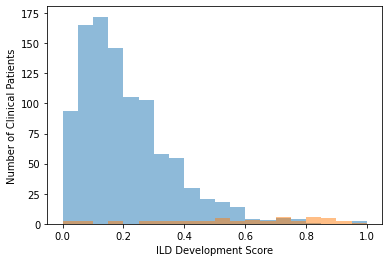

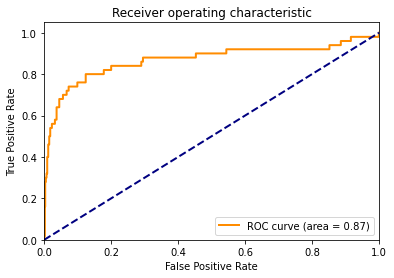

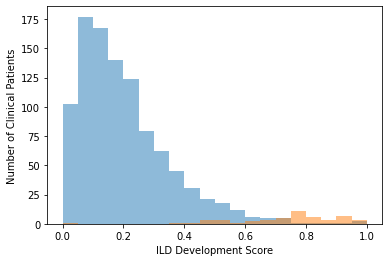

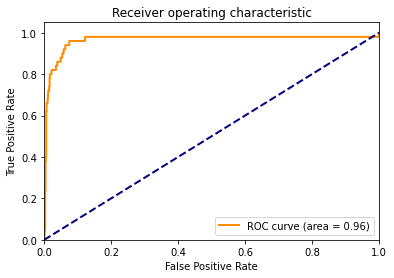

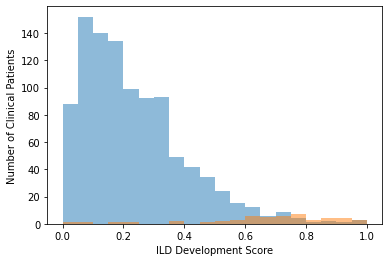

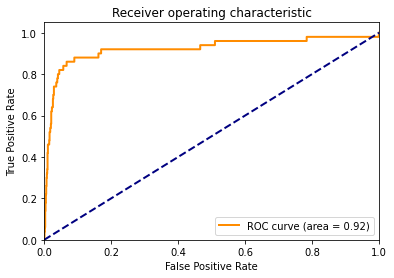

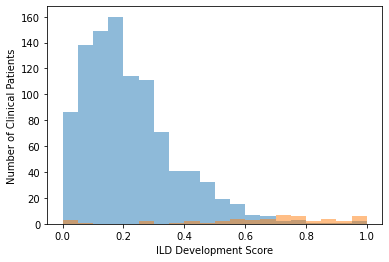

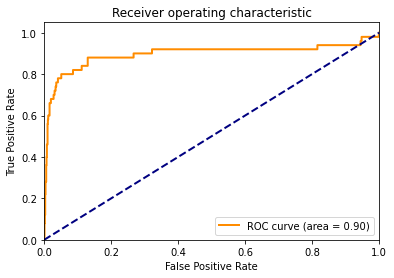

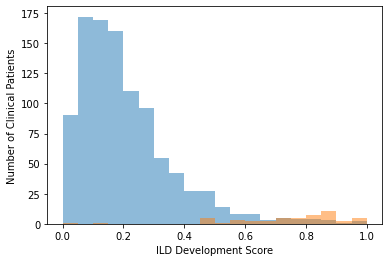

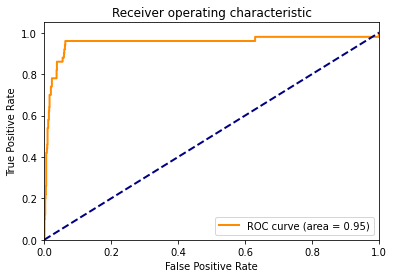

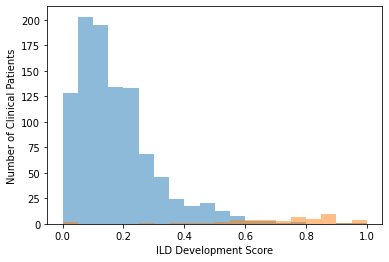

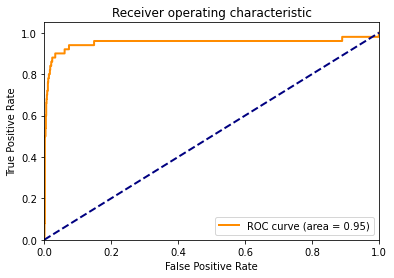

AUC: 0.94 +/- 0.03


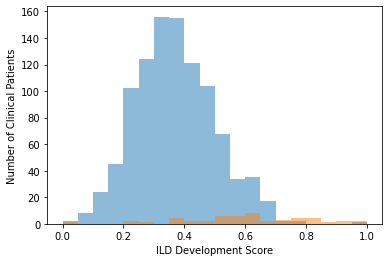

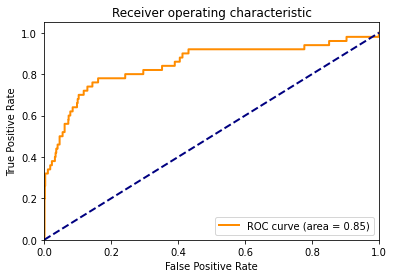

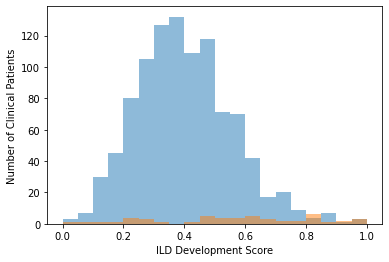

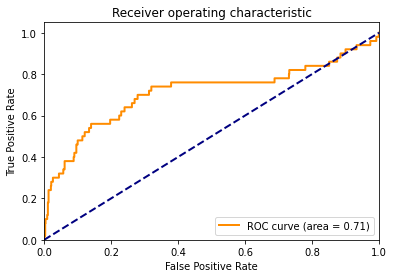

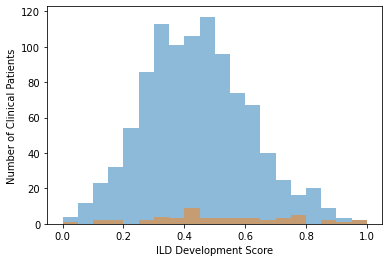

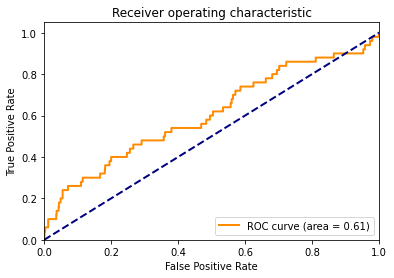

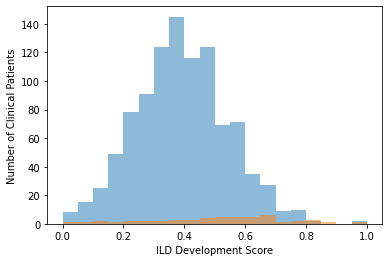

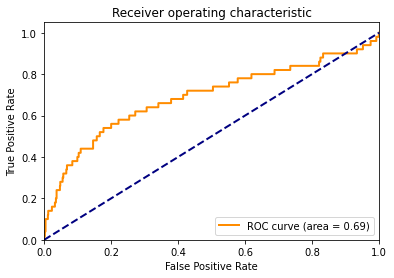

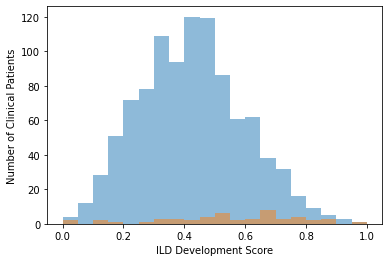

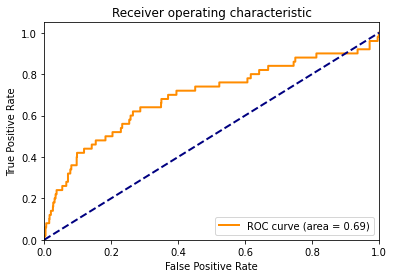

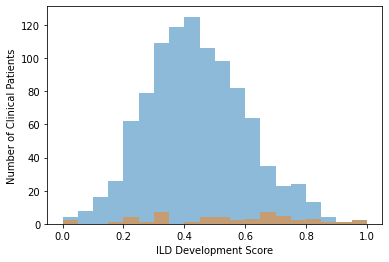

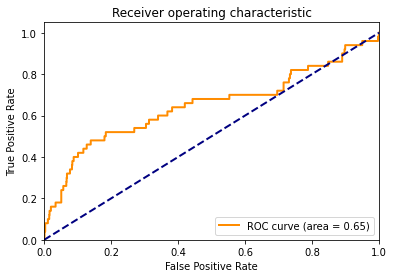

AUC: 0.72 +/- 0.09


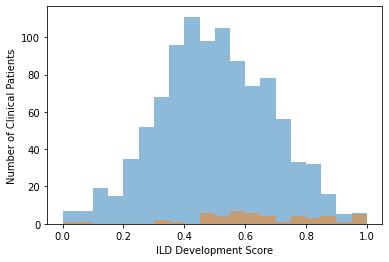

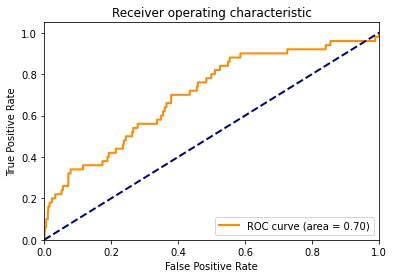

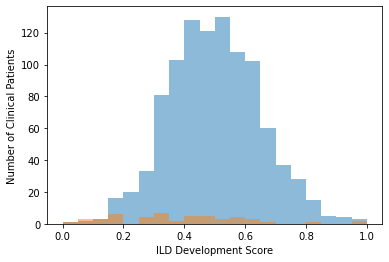

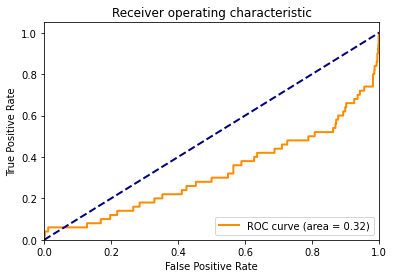

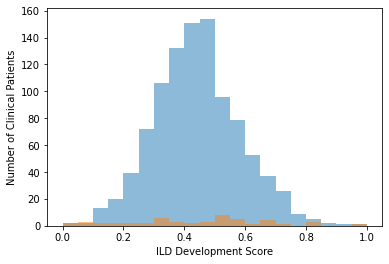

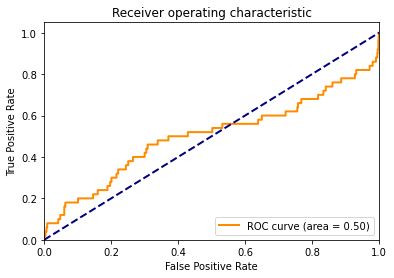

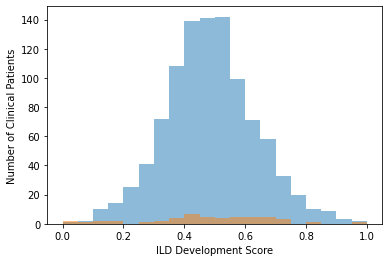

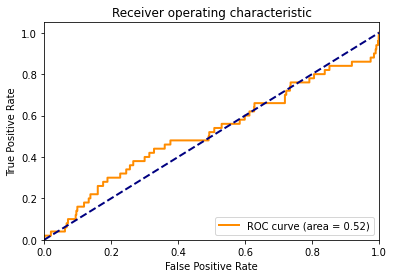

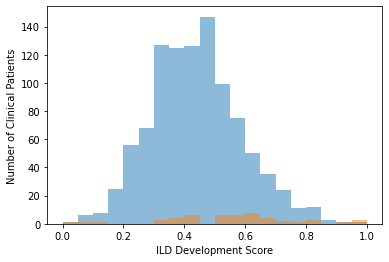

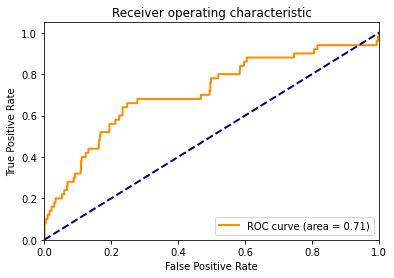

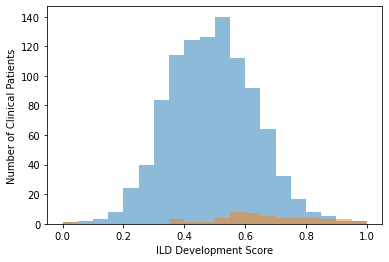

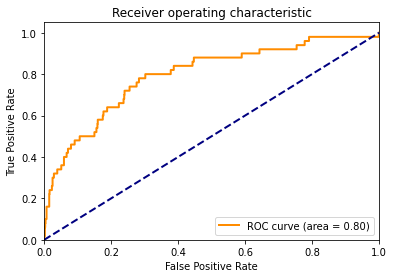

AUC: 0.62 +/- 0.11


In [14]:
run2 = generateScoreDistributions( shapeD=(2,2), scaleD=(10,10), samplesD=(1e3,50), nTrials=1000)
run25 = generateScoreDistributions( shapeD=(25,25), scaleD=(10,10), samplesD=(1e3,50), nTrials=1000)
run100 = generateScoreDistributions( shapeD=(100,100), scaleD=(10,10), samplesD=(1e3,50), nTrials=1000)

In [15]:
# ** Combine all dicts
runs= [run2, run25, run100]
combined = {}
for key in runs[0].keys():
    combined[key] = []
    for run in runs:
        combined[key].extend(run[key])

In [16]:
# ** Make pandas df
df = pd.DataFrame.from_dict(combined)


In [30]:
def fit_gaussian(x, A, mu, sigma):
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

def fit_skewGaussian(x, A, mu, sigma, gamma):
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)) * (1+erf( (gamma*(x-mu))/(sigma*np.sqrt(2)))) )

def fit_gamma(x, A, mu, sigma): # FIXME, this is a copy+paste of gaussian
    return (A * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))


def fitHistogram( _bins, _counts, _rate, fitOption='gaus'):
    """function for fitting histogram because apparently this isn't simply native somewhere"""
    
    # *** 0. Calculate bin centers from 'bins' object returned from matplotlib
    _binCenters = 0.5*(_bins[1:]+_bins[:-1])
    _nSigma = 1
    _rateMean = np.mean(_rate)
    _rateStd  = np.std(_rate)
    _fitRangeMin = max( 0, list(map(lambda i: i> (_rateMean - _nSigma*_rateStd), _binCenters)).index(True))
    _fitRangeMax = min( len(_counts), list(map(lambda i: i> (_rateMean + _nSigma*_rateStd), _binCenters)).index(True))
    
    # *** 1. Define fit function
    _fitFunction = []
    _p0 = []
    if fitOption == 'gaus':
        _fitFunction = fit_gaussian
        _p0 = [max(_counts), _rateMean, _rateStd]
    elif fitOption == 'skewGaus':
        _fitFunction = fit_skewGaussian
        _p0 = [max(_counts), _rateMean, _rateStd, 0]
    elif fitOption == 'gamma':
        _fitFunction = fit_gamma
        
    # *** 2. Fit the function to the histogram data
    print(max(_counts), np.mean(_rate), np.std(_rate))
    
    try:
        _popt, _pcov = curve_fit(_fitFunction, 
                                 xdata=_binCenters[_fitRangeMin:_fitRangeMax], 
                                 ydata=_counts[_fitRangeMin:_fitRangeMax], 
                                 #xdata=_binCenters, 
                                 #ydata=_counts, 
                                 p0=_p0,
                                )
        print(_popt)
    except:
        print("!!!!!!!!!  FIT FAILED  !!!!!!!!!!!")
        return -99, -99, -99
    
    # *** 3. Plot fit function
    # Generate enough x values to make the curves look smooth.
    _xMin = max( _popt[1] - _nSigma*_popt[2], min(_bins))
    _xMax = min( _popt[1] + _nSigma*_popt[2], max(_bins))
    _xspace = np.linspace( _xMin, _xMax, 10000)

    plt.plot(_xspace, _fitFunction(_xspace, *_popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    plt.plot([_popt[1], _popt[1]], [0, max(_counts)], color='navy', lw=2, linestyle='--')

    # *** 4. Calculate chi^2/NDF
    _chi2 = 0
    _ndf = (_fitRangeMax - _fitRangeMin) + 1 - len(_popt) # N_bins + n_freeParametersInFit
    
    for _iBin in range(_fitRangeMin,_fitRangeMax):
        _chi2 += (_fitFunction( _binCenters[_iBin], *_popt) - _counts[_iBin])**2 / np.sqrt(_counts[_iBin])
    
    print('Chi^2 / NDF : {:.2f} / {:.2f} = {:.2f}'.format(_chi2, _ndf, _chi2/_ndf))
        
    # *** 5. Add some text to plot
    _labelX = 0.7 if _popt[1] < 0.5 else 0.1
    plt.text(_labelX*_bins[-1], .84*max(_counts), '$\mu$ = {:.3f}'.format( _popt[1]), fontsize=12)
    plt.text(_labelX*_bins[-1], .76*max(_counts), '$\sigma$ = {:.3f}'.format( _popt[2]), fontsize=12)
    plt.text(_labelX*_bins[-1], .68*max(_counts), '$\chi^2$/NDF = {:.2f}'.format( _chi2/_ndf), fontsize=12)

    return _popt[1], _popt[2], _chi2/_ndf # mean, std, chi2/ndf


def plotRateHistogram(_rate, _xlabel, _ylabel, _title, drawFit=False, fitOption='gaus'):
    """helper function for plotting normed rates"""
    
    _weights = np.ones_like(_rate) / len(_rate)
    _nBins= np.linspace(0,1,26)
    #if 'False' in _xlabel:
    #    _nBins= np.linspace(0,.30,60)
  
    _counts, _bins, _patches = plt.hist(_rate, bins=_nBins)#, weights=_weights)
  
    plt.xlabel( _xlabel)
    plt.ylabel( _ylabel)
    plt.title( _title)
    
    #_xMin = max(-0.05, _mean - 10*_std)
    #_xMax = min(1.05, _mean + 10*_std)
    #plt.xlim([_xMin, _xMax])
    plt.xlim([-0.05, 1.05])
    
    if drawFit:
        _mean, _std, _chi2ndf = fitHistogram( _bins, _counts, _rate, fitOption)
        
    plt.show()
    
    return 

179.0 0.82914 0.09099044125621107
[1.78096436e+02 8.82403517e-01 1.07747974e-01]
Chi^2 / NDF : 15.25 / 3.00 = 5.08


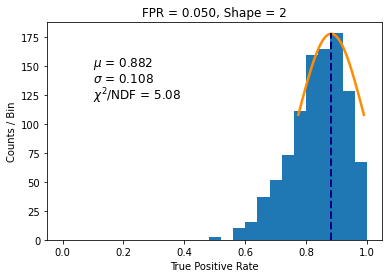

112.0 0.33546 0.14597187537330608
[106.97662562   0.28771871   0.18266245]
Chi^2 / NDF : 12.77 / 5.00 = 2.55


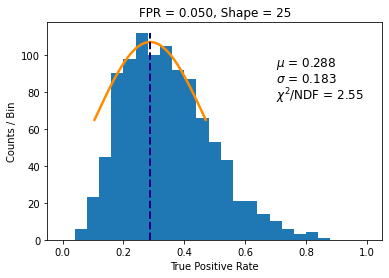

138.0 0.22654000000000002 0.11931818134718615
[1.35683547e+02 1.97058178e-01 1.25101243e-01]
Chi^2 / NDF : 2.50 / 4.00 = 0.62


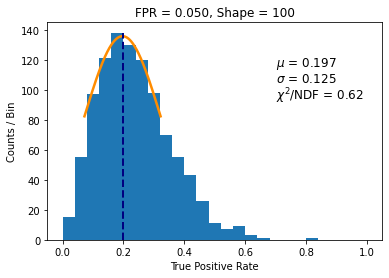

In [31]:
# ** Plot some histograms and FIT!

plotRateHistogram(run2['fpr050'], 'True Positive Rate', 'Counts / Bin', 'FPR = 0.050, Shape = 2', drawFit=True)
plotRateHistogram(run25['fpr050'], 'True Positive Rate', 'Counts / Bin', 'FPR = 0.050, Shape = 25', drawFit=True)
plotRateHistogram(run100['fpr050'], 'True Positive Rate', 'Counts / Bin', 'FPR = 0.050, Shape = 100', drawFit=True)


In [ ]:
shapeD = (1.5, 1.5)  #this sets how distinguishable the samples are
scaleD = (10, 10)
samplesD = (1e3, 50)
#samplesD = (10e3, 1e3)
#samplesD = (1e3, 1e3)

run_auc = []
true_tpr60  = []
false_tpr60 = []
true_fpr10  = []
false_fpr10 = []

tprThreshold = 0.80
fprThreshold = 0.05
nTrials = 10e3

for _ in range(0, int(nTrials)):
    
    # for results, 0: auc, 1: fpr, 2: tpr, 3: non-ILD predictions, 4: ILD predictions
    
    _showPlots = True if _ < 5 else False    
    _results = produceTwoDistributions( shape=shapeD, scale=scaleD, nSamples=samplesD, showPlots=_showPlots) 
    
    run_auc.append( _results['auc'] )
    
    trueRate_tpr60, falseRate_tpr60 = getRateGivenThreshold( tprThreshold, _results['tpr'], _results['fpr'])
    falseRate_fpr10, trueRate_fpr10 = getRateGivenThreshold( fprThreshold, _results['fpr'], _results['tpr'])
    
    true_tpr60.append(trueRate_tpr60)
    false_tpr60.append(falseRate_tpr60)

    true_fpr10.append(trueRate_fpr10)
    false_fpr10.append(falseRate_fpr10)
    
    if _showPlots:
        print("Len FPR: {}".format(len(_results['fpr'])))
        print("Len TPR: {}".format(len(_results['tpr'])))

    if falseRate_fpr10 > 0.9:
        print("FPR: {}".format(falseRate_fpr10))
        plotROC(_results['auc'], _results['fpr'], _results['tpr'])
        plotPredictions(_results['nonILD'], _results['ILD'])

print("AUC: {:.2f} +/- {:.2f}".format( np.mean(run_auc), np.std(run_auc)))


In [ ]:
plotRateHistogram(true_tpr60, 'True Positive Rate', 'Counts / Bin', 'TPR = {}'.format(tprThreshold))
plotRateHistogram(false_tpr60, 'False Positive Rate', 'Counts / Bin', 'TPR = {}'.format(tprThreshold))#, drawFit=True)
#plotRateHistogram(false_tpr60, 'False Positive Rate', 'Counts / Bin', 'TPR = {}'.format(tprThreshold), drawFit=True, fitOption='skewGaus')
plotRateHistogram(true_fpr10, 'True Positive Rate', 'Counts / Bin', 'FPR = {}'.format(fprThreshold), drawFit=True)
#plotRateHistogram(true_fpr10, 'True Positive Rate', 'Counts / Bin', 'FPR = {}'.format(fprThreshold), drawFit=True, fitOption='skewGaus')
plotRateHistogram(false_fpr10, 'False Positive Rate', 'Counts / Bin', 'FPR = {}'.format(fprThreshold))

In [ ]:
P( B | A) = P(A)*P(B) / P(A|B)

In [ ]:
B = correctly predicting ILD in 75% of ILD-positive patients
A = incorrectly predicting ILD in 50% of ILD-negative patients